In [56]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import random
import os
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
import xgboost as xgb
%matplotlib inline
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(42) # Seed 고정

# 데이터 소환

In [57]:
# 일반 데이터 소환
from sklearn.model_selection import train_test_split

train_df = pd.read_csv('./train.csv')
test_df = pd.read_csv("./test.csv")

train_df, valid_df = train_test_split(train_df, train_size=0.8,random_state=42)

X_train = train_df.iloc[:,:57].drop(["ID","X_04","X_23","X_47","X_48"],axis = 1)
y_train = train_df.iloc[:,57]

X_test = valid_df.iloc[:,:57].drop(["ID","X_04","X_23","X_47","X_48"],axis = 1)
y_test = valid_df.iloc[:,57]


,X_01,X_02,X_03,X_05,X_06,X_07,X_08,X_09,X_10,X_11,...,X_45,X_46,X_49,X_50,X_51,X_52,X_53,X_54,X_55,X_56
38194,70.544,103.32,66.17,103.150,70.904,29.56,95.41,158.21,0.0,0.0,...,0.15,1469,12544.13,134.682210,129.947949,139.472643,132.299986,124.762020,133.686459,134.556606
21557,67.485,103.32,65.17,102.048,69.884,29.85,105.58,117.71,0.0,0.0,...,0.15,1469,12624.33,132.298199,138.071385,143.807214,132.119505,125.568508,138.441121,124.334309
4562,70.544,103.32,72.37,103.154,70.904,28.93,116.56,278.62,0.0,0.0,...,0.10,1469,18394.33,125.810010,122.519528,132.610788,130.748144,120.680096,134.852993,124.379109
39428,67.485,103.32,65.57,101.891,68.864,32.07,116.43,234.22,0.0,0.0,...,0.21,1469,26607.53,129.868550,129.021214,141.274553,130.210280,128.719257,143.581967,128.091419
15695,67.485,103.32,65.17,101.945,67.845,31.44,105.68,332.51,0.0,0.0,...,0.25,1469,16703.43,124.206837,130.821041,135.350626,125.720045,131.959202,144.584767,129.742230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6265,69.524,103.32,71.97,101.870,70.904,48.24,120.52,608.69,0.0,0.0,...,0.19,1469,15585.73,124.925084,124.813091,123.314043,116.561773,119.467594,122.416775,123.261044
11284,68.504,103.32,71.67,101.935,72.943,30.90,119.81,268.32,0.0,0.0,...,0.13,1469,14228.73,126.370267,130.973187,135.857515,133.020071,132.835186,130.027691,126.445255
38158,71.563,103.32,66.77,103.156,71.923,28.67,2362.16,37.58,0.0,0.0,...,0.13,1469,12088.23,137.139912,134.100041,147.350031,130.241667,134.185695,147.163205,133.407581
860,68.504,103.32,70.67,101.966,68.864,29.44,232.11,200.89,0.0,0.0,...,0.20,1469,19974.53,130.648595,127.940746,135.476869,124.291716,122.022510,128.166859,124.283352


In [66]:
from sklearn import metrics 
def lg_nrmse(gt, preds):
    # 각 Y Feature별 NRMSE 총합
    # Y_01 ~ Y_08 까지 20% 가중치 부여
    all_nrmse = []
    for idx in range(0,14): # ignore 'ID'
        rmse = metrics.mean_squared_error(gt[:,idx], preds[:,idx], squared=False)
        nrmse = rmse/np.mean(np.abs(gt[:,idx]))
        all_nrmse.append(nrmse)
    print(all_nrmse[:8])
    score = 1.2 * np.sum(all_nrmse[:8]) + 1.0 * np.sum(all_nrmse[8:14])
    return score

# 모델 설계

In [55]:
import tensorflow as tf
def my_loss(y_true, y_pred):
    # 내가 정의한 손실 함수
    error = y_true - y_pred
    rmse=tf.math.sqrt(tf.reduce_mean(tf.math.square(error)))
    nrmse = rmse/tf.math.reduce_mean(tf.math.abs (y_true))
    return nrmse

def my_metric(y_true, y_pred):  
    error = y_true - y_pred
    rmse=tf.math.sqrt(tf.reduce_mean(tf.math.square(error)))
    nrmse = rmse/tf.math.reduce_mean(tf.math.abs(y_true))
    return nrmse

In [59]:

def my_model():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(units=100, activation='relu',input_shape=(52,)))
    model.add(tf.keras.layers.Dense(units=50, activation='relu'))
    model.add(tf.keras.layers.Dense(units=10, activation='relu'))
    model.add(tf.keras.layers.Dense(units=4, activation='relu'))
    return model

# model을 생성합니다
model = my_model()
# model을 compile 합니다. loss와 metric에는 내가 만든 함수를 대입합니다
model.compile(optimizer='adam', loss=my_loss, metrics=[my_metric])


# 새로운 마음으로

In [78]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer

cancer = load_breast_cancer()

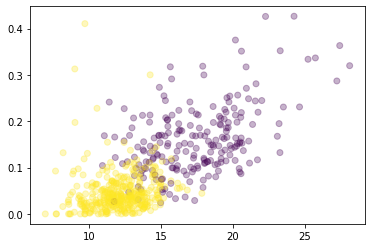

In [80]:
col1 = 0
col2 = 6

plt.scatter(cancer.data[:,col1], cancer.data[:,col2], c= cancer.target, alpha=0.3)

## 따라해보자

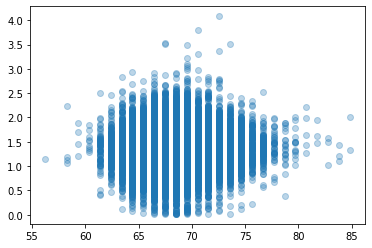

In [96]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer


plt.scatter(train_df["X_01"], y_train, alpha=0.3)

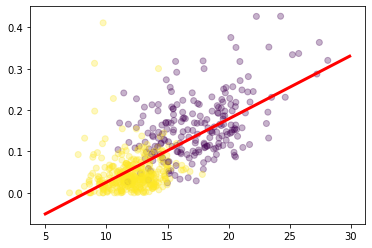

In [93]:

from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(cancer.data[:,[col1]], cancer.data[:,col2])

model.coef_, model.intercept_
xs = np.arange(5,30,0.1)
ys = xs*model.coef_[0] + model.intercept_

plt.scatter(cancer.data[:,col1], cancer.data[:,col2], c= cancer.target, alpha=0.3)
plt.plot(xs,ys,'r-',lw=3)

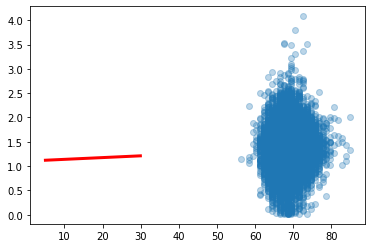

In [105]:

from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(train_df[["X_01"]], y_train)

model.coef_, model.intercept_
xs = np.arange(5,30,0.1)
ys = xs*model.coef_[0] + model.intercept_

plt.scatter(train_df["X_01"], y_train, alpha=0.3)
plt.plot(xs,ys,'r-',lw=3)

In [106]:
model.coef_[0]

0.0036300447304422447